# Lambda Iterations

In [1]:
import os
import sys

magritteFolder = '/home/frederik/Dropbox/GitHub/Magritte/'

sys.path.append(magritteFolder)

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

In [2]:
def max_relative_difference(a, b):
    return np.max(2.0 * np.abs((a - b) / (a + b)))

In [3]:
def VZp1_pops(nod):

    dimension = 1
    npoints   = 100
    nrays     = 200
    nspecs    = 5
    nlspecs   = 1
    nquads    = 15

    r_in   = 1.0E13   # [m]
    r_out  = 7.8E16   # [m]
    nH2_in = 2.0E13   # [m^-3]
    X_mol  = 1.0E-6   # [.]
    temp   = 20.0     # [K]
    turb   = 150.00   # [.]


    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)


    rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


    modelFile = 'vanZadelhoff_1a_1D.hdf5'
    lamdaFile = f'{magritteFolder}tests/data/test.txt'


    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(True)
    model.parameters.set_pop_prec          (1.0e-6)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)
    model.parameters.n_off_diag            = nod

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set(np.zeros((npoints, 3)))

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_rays_spherical_symmetry (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()
    model.read ()

    model.compute_spectral_discretisation ()
    model.compute_inverse_line_widths     ()
    model.compute_LTE_level_populations   ()

    Nmax = 100

    max_diffs = []

    pops = []
    pop    = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)

    for it in range(Nmax):
        # Compute radiation field and resulting populations
        model.compute_radiation_field_feautrier_order_2()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
        
        pops.append(pop)
        max_diff = max_relative_difference(pops[-1], pops[-2])
        max_diffs.append(max_diff)
        # Check for convergence
#         if (max_diff < 1.0e-6):
#             break
        print('After', it, 'iteration(s), max_diff =', max_diff)
        
    return pops, max_diffs

In [4]:
pops, max_diffs = VZp1_pops(0)

After 0 iteration(s), max_diff = 0.67532867319667438163
After 1 iteration(s), max_diff = 0.41134736876887022407
After 2 iteration(s), max_diff = 0.25672685590981898275
After 3 iteration(s), max_diff = 0.1902453155089560047
After 4 iteration(s), max_diff = 0.1523181743951932173
After 5 iteration(s), max_diff = 0.12759521660850900572
After 6 iteration(s), max_diff = 0.110074748116086370804
After 7 iteration(s), max_diff = 0.09733701897109957774
After 8 iteration(s), max_diff = 0.08731154741671383308
After 9 iteration(s), max_diff = 0.079329335412878955825
After 10 iteration(s), max_diff = 0.07292661318096562752
After 11 iteration(s), max_diff = 0.06758406046136118653
After 12 iteration(s), max_diff = 0.06306637782956355452
After 13 iteration(s), max_diff = 0.05919545288459485238
After 14 iteration(s), max_diff = 0.055835172958732542827
After 15 iteration(s), max_diff = 0.05294965639144907682
After 16 iteration(s), max_diff = 0.05042596695045739735
After 17 iteration(s), max_diff = 0.0481

In [5]:
from matplotlib import pyplot   as plt
from matplotlib import gridspec, rcParams, rc, cm, colors

rcParams.update({'font.size': 13})
rc('text', usetex=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [27]:
def compute_acceleration_steps(l):

    Ys = np.array(pops, dtype=float)
#     Ys = Ys[10:,:]
    Es = []

    for i in range(2, Ys.shape[0]+1):
        ys = Ys[:i,:]
        rs = ys[1:,:] - ys[:-1,:]
        cs = np.linalg.solve(np.matmul(rs, rs.T) + l*np.eye(rs.shape[0]), np.ones(rs.shape[0]))
        cs = cs / np.sum(cs)
        nw = np.matmul(cs, ys[:-1,:])

        Es.append(nw)
    
    Es = np.array(Es)
    Ds = np.max(0.5*(Es[1:,:] - Es[:-1,:])/(Es[1:,:] + Es[:-1,:]), axis=1)
    
    return Es, Ds

In [28]:
Es_i, Ds_i = compute_acceleration_steps(0.0)
Es_0, Ds_0 = compute_acceleration_steps(1.0e-0)
Es_2, Ds_2 = compute_acceleration_steps(1.0e-2)
Es_4, Ds_4 = compute_acceleration_steps(1.0e-4)
Es_8, Ds_8 = compute_acceleration_steps(1.0e-8)

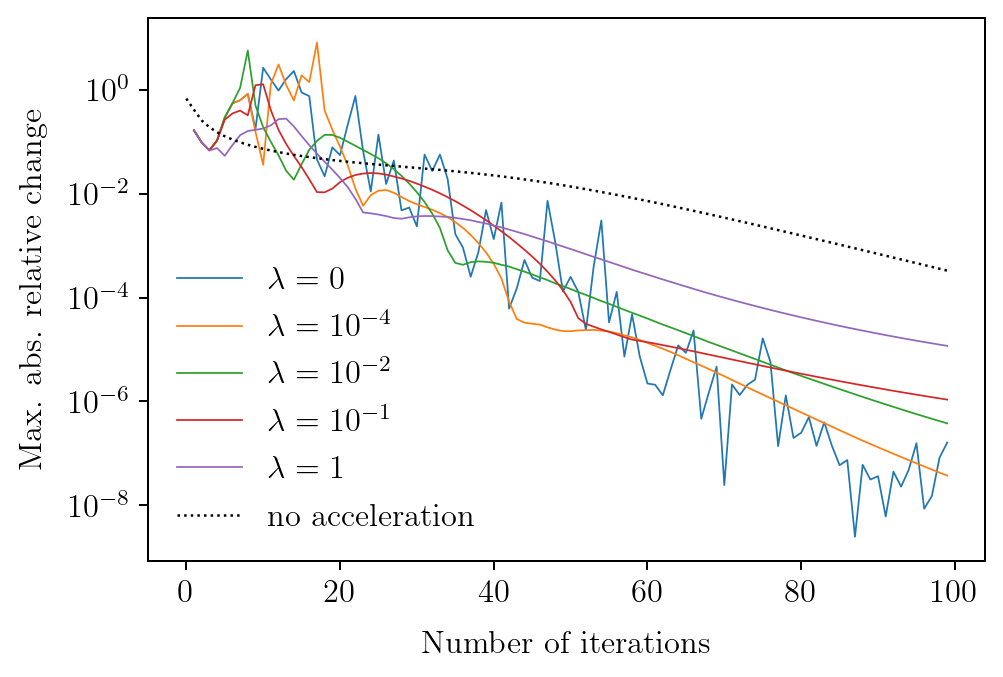

In [65]:
plt.figure(dpi=180)

plt.plot(range(1, len(max_diffs)), Ds_i, label=r'$\lambda=0$',           linewidth=.7)
plt.plot(range(1, len(max_diffs)), Ds_8, label=r'$\lambda=10^{-4}$',     linewidth=.7)
plt.plot(range(1, len(max_diffs)), Ds_4, label=r'$\lambda=10^{-2}$',     linewidth=.7)
plt.plot(range(1, len(max_diffs)), Ds_2, label=r'$\lambda=10^{-1}$',     linewidth=.7)
plt.plot(range(1, len(max_diffs)), Ds_0, label=r'$\lambda=1$',           linewidth=.7)
plt.plot(max_diffs, c='k', linestyle='dotted', label='no acceleration',   linewidth=1)

plt.yscale('log')
# plt.ylim((5.0e-11, 30))
# plt.xlim((-3, 130))
plt.xlabel('Number of iterations', labelpad=9)
plt.ylabel('Max. abs. relative change',  labelpad=9)
plt.legend(frameon=False, fancybox=False)

ax = plt.gca()
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor', reset=True)

y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)

plt.savefig('regularised_acceleration_steps.pdf', bbox_inches='tight')

In [10]:
def Ng_acceleration(pops, order):

    Ys = np.array(pops, dtype=float)
    Ys = Ys[-order:,:]

    ys = Ys
    rs = ys[1:,:] - ys[:-1,:]
    cs = np.linalg.solve(np.matmul(rs, rs.T), np.ones(rs.shape[0]))
    cs = cs / np.sum(cs)
    nw = np.matmul(cs, ys[:-1,:])

    return nw

In [11]:
def VZp1_pops_Ng(nod, order):

    dimension = 1
    npoints   = 100
    nrays     = 200
    nspecs    = 5
    nlspecs   = 1
    nquads    = 15

    r_in   = 1.0E13   # [m]
    r_out  = 7.8E16   # [m]
    nH2_in = 2.0E13   # [m^-3]
    X_mol  = 1.0E-6   # [.]
    temp   = 20.0     # [K]
    turb   = 150.00   # [.]


    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)


    rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


    modelFile = 'vanZadelhoff_1a_1D.hdf5'
    lamdaFile = f'{magritteFolder}tests/data/test.txt'


    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(True)
    model.parameters.set_pop_prec          (1.0e-6)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)
    model.parameters.n_off_diag            = nod

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set(np.zeros((npoints, 3)))

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_rays_spherical_symmetry (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()
    model.read ()

    model.compute_spectral_discretisation ()
    model.compute_inverse_line_widths     ()
    model.compute_LTE_level_populations   ()

    Nmax = 100

    max_diffs = []

    pops = []
    pop    = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)

    for it in range(Nmax):
        # Compute radiation field and resulting populations
        model.compute_radiation_field_feautrier_order_2()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
        
        pops.append(pop)
                
        max_diff = max_relative_difference(pops[-1], pops[-2])
        max_diffs.append(max_diff)
        # Check for convergence
#         if (max_diff < 1.0e-6):
#             break
        print('After', it, 'iteration(s), max_diff =', max_diff)
            
        if (len(pops)%order == 0) and (len(pops) > 20):
            print('Acceleration!')
            nw = Ng_acceleration(pops, order)
            
            model.lines.lineProducingSpecies[0].population = np.array(nw, dtype=np.float128)
            model.lines.set_emissivity_and_opacity()
            

        
    return pops, max_diffs

In [12]:
# pops_0,  max_diffs_0  = VZp1_pops_Ng(0,1000)
# pops_3,  max_diffs_3  = VZp1_pops_Ng(0,3)
# pops_6,  max_diffs_6  = VZp1_pops_Ng(0,6)
# pops_9,  max_diffs_9  = VZp1_pops_Ng(0,9)
# pops_12, max_diffs_12 = VZp1_pops_Ng(0,12)
# pops_15, max_diffs_15 = VZp1_pops_Ng(0,15)

In [13]:
pops_0p,  max_diffs_0p  = VZp1_pops_Ng(0,1000)
pops_2p,  max_diffs_2p  = VZp1_pops_Ng(0,2)
pops_4p,  max_diffs_4p  = VZp1_pops_Ng(0,4)
pops_8p,  max_diffs_8p  = VZp1_pops_Ng(0,8)
pops_16p, max_diffs_16p = VZp1_pops_Ng(0,16)
pops_32p, max_diffs_32p = VZp1_pops_Ng(0,32)

After 0 iteration(s), max_diff = 0.67532867319667438163
After 1 iteration(s), max_diff = 0.41134736876887022407
After 2 iteration(s), max_diff = 0.25672685590981898275
After 3 iteration(s), max_diff = 0.1902453155089560047
After 4 iteration(s), max_diff = 0.1523181743951932173
After 5 iteration(s), max_diff = 0.12759521660850900572
After 6 iteration(s), max_diff = 0.110074748116086370804
After 7 iteration(s), max_diff = 0.09733701897109957774
After 8 iteration(s), max_diff = 0.08731154741671383308
After 9 iteration(s), max_diff = 0.079329335412878955825
After 10 iteration(s), max_diff = 0.07292661318096562752
After 11 iteration(s), max_diff = 0.06758406046136118653
After 12 iteration(s), max_diff = 0.06306637782956355452
After 13 iteration(s), max_diff = 0.05919545288459485238
After 14 iteration(s), max_diff = 0.055835172958732542827
After 15 iteration(s), max_diff = 0.05294965639144907682
After 16 iteration(s), max_diff = 0.05042596695045739735
After 17 iteration(s), max_diff = 0.0481

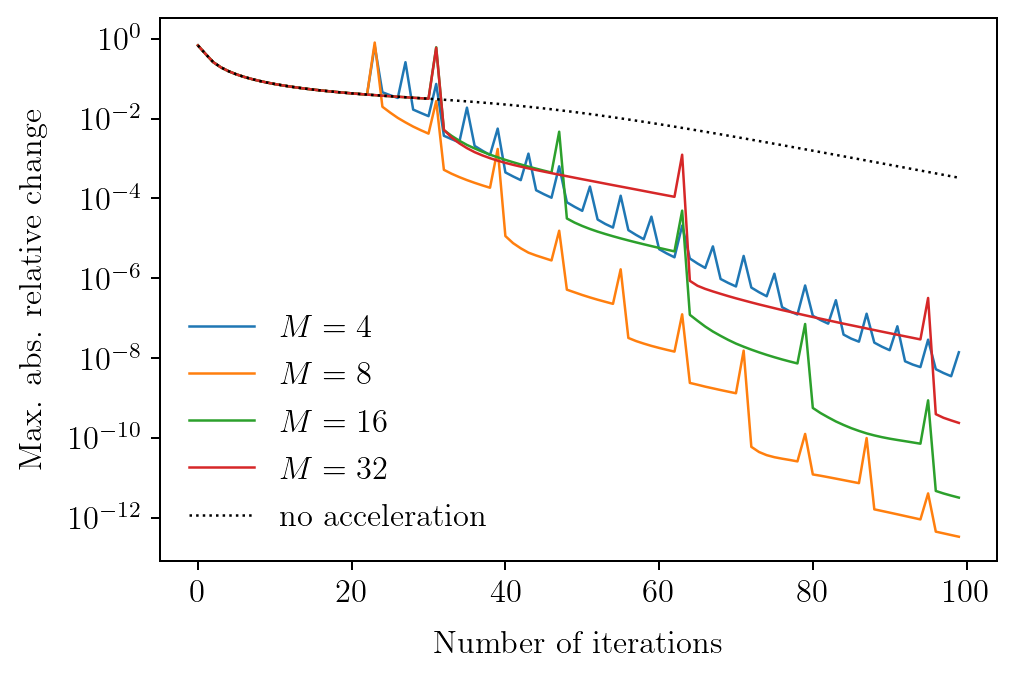

In [64]:
plt.figure(dpi=180)
# plt.plot(max_diffs_2,  label=r'$M=2$',  linewidth=1)
plt.plot(max_diffs_4p,  label=r'$M=4$',  linewidth=1)
plt.plot(max_diffs_8p,  label=r'$M=8$',  linewidth=1)
plt.plot(max_diffs_16p, label=r'$M=16$', linewidth=1)
plt.plot(max_diffs_32p, label=r'$M=32$', linewidth=1)
plt.yscale('log')
# plt.xlim((-5, 100))
# plt.ylim((.5e-9, 50))
# plt.axhline(1.0e-6, c='grey', linewidth=.5, linestyle='dashed')
plt.xlabel('Number of iterations',      labelpad=9)
plt.ylabel('Max. abs. relative change', labelpad=9)


plt.plot(max_diffs, label='no acceleration',  c='k', linestyle='dotted', linewidth=1)
plt.legend(fancybox=False, facecolor='white', edgecolor='white')

plt.savefig('Ng-acceleration_20_wait.pdf', bbox_inches='tight')

In [16]:
def Ng_acceleration(pops, order):

    Ys = np.array(pops, dtype=float)
    Ys = Ys[-order:,:]

    ys = Ys
    rs = ys[1:,:] - ys[:-1,:]
    cs = np.linalg.solve(np.matmul(rs, rs.T), np.ones(rs.shape[0]))
    cs = cs / np.sum(cs)
    nw = np.matmul(cs, ys[:-1,:])

    return nw

In [17]:
def VZp1_pops_Ng(nod, order):

    dimension = 1
    npoints   = 100
    nrays     = 200
    nspecs    = 5
    nlspecs   = 1
    nquads    = 15

    r_in   = 1.0E13   # [m]
    r_out  = 7.8E16   # [m]
    nH2_in = 2.0E13   # [m^-3]
    X_mol  = 1.0E-6   # [.]
    temp   = 20.0     # [K]
    turb   = 150.00   # [.]


    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)


    rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


    modelFile = 'vanZadelhoff_1a_1D.hdf5'
    lamdaFile = f'{magritteFolder}tests/data/test.txt'


    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(True)
    model.parameters.set_pop_prec          (1.0e-6)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)
    model.parameters.n_off_diag            = nod

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set(np.zeros((npoints, 3)))

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_rays_spherical_symmetry (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()
    model.read ()

    model.compute_spectral_discretisation ()
    model.compute_inverse_line_widths     ()
    model.compute_LTE_level_populations   ()

    Nmax = 100

    max_diffs = []

    pops = []
    pop    = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)

    for it in range(Nmax):
        # Compute radiation field and resulting populations
        model.compute_radiation_field_feautrier_order_2()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
        
        pops.append(pop)
                
        max_diff = max_relative_difference(pops[-1], pops[-2])
        max_diffs.append(max_diff)
        # Check for convergence
#         if (max_diff < 1.0e-6):
#             break
        print('After', it, 'iteration(s), max_diff =', max_diff)
            
        if (len(pops)%order == 0) and len(pops)>2:
            print('Acceleration!')
            nw = Ng_acceleration(pops, order)
            
            model.lines.lineProducingSpecies[0].population = np.array(nw, dtype=np.float128)
            model.lines.set_emissivity_and_opacity()
            

        
    return pops, max_diffs

In [18]:
# pops_0,  max_diffs_0  = VZp1_pops_Ng(0,1000)
# pops_3,  max_diffs_3  = VZp1_pops_Ng(0,3)
# pops_6,  max_diffs_6  = VZp1_pops_Ng(0,6)
# pops_9,  max_diffs_9  = VZp1_pops_Ng(0,9)
# pops_12, max_diffs_12 = VZp1_pops_Ng(0,12)
# pops_15, max_diffs_15 = VZp1_pops_Ng(0,15)

In [19]:
pops_0,  max_diffs_0  = VZp1_pops_Ng(0,1000)
pops_2,  max_diffs_2  = VZp1_pops_Ng(0,2)
pops_4,  max_diffs_4  = VZp1_pops_Ng(0,4)
pops_8,  max_diffs_8  = VZp1_pops_Ng(0,8)
pops_16, max_diffs_16 = VZp1_pops_Ng(0,16)
pops_32, max_diffs_32 = VZp1_pops_Ng(0,32)

After 0 iteration(s), max_diff = 0.67532867319667438163
After 1 iteration(s), max_diff = 0.41134736876887022407
After 2 iteration(s), max_diff = 0.25672685590981898275
After 3 iteration(s), max_diff = 0.1902453155089560047
After 4 iteration(s), max_diff = 0.1523181743951932173
After 5 iteration(s), max_diff = 0.12759521660850900572
After 6 iteration(s), max_diff = 0.110074748116086370804
After 7 iteration(s), max_diff = 0.09733701897109957774
After 8 iteration(s), max_diff = 0.08731154741671383308
After 9 iteration(s), max_diff = 0.079329335412878955825
After 10 iteration(s), max_diff = 0.07292661318096562752
After 11 iteration(s), max_diff = 0.06758406046136118653
After 12 iteration(s), max_diff = 0.06306637782956355452
After 13 iteration(s), max_diff = 0.05919545288459485238
After 14 iteration(s), max_diff = 0.055835172958732542827
After 15 iteration(s), max_diff = 0.05294965639144907682
After 16 iteration(s), max_diff = 0.05042596695045739735
After 17 iteration(s), max_diff = 0.0481

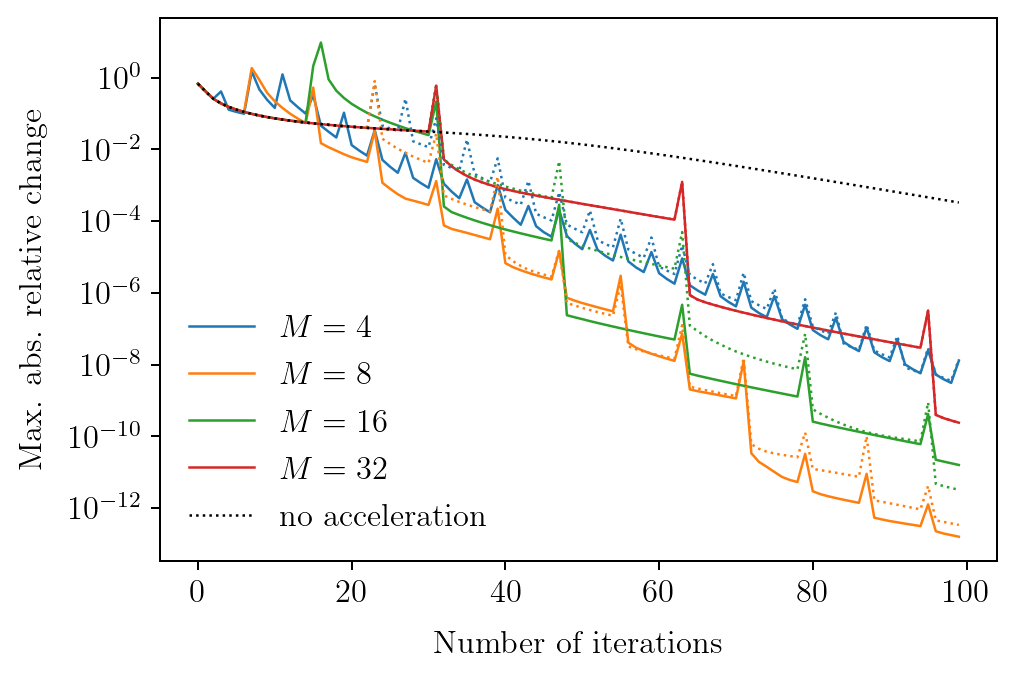

In [63]:
plt.figure(dpi=180)
# plt.plot(max_diffs_2,  label=r'$M=2$',  linewidth=1)
plt.plot(max_diffs_4,  label=r'$M=4$',  linewidth=1)
plt.plot(max_diffs_8,  label=r'$M=8$', linewidth=1)
plt.plot(max_diffs_16, label=r'$M=16$', linewidth=1)
plt.plot(max_diffs_32, label=r'$M=32$', linewidth=1)

plt.plot(max_diffs_4p,  c='tab:blue',   linewidth=1, linestyle='dotted')
plt.plot(max_diffs_8p,  c='tab:orange', linewidth=1, linestyle='dotted')
plt.plot(max_diffs_16p, c='tab:green',  linewidth=1, linestyle='dotted')
plt.plot(max_diffs_32p, c='tab:red',    linewidth=1, linestyle='dotted')

plt.yscale('log')
# plt.xlim((-5, 100))
# plt.ylim((.5e-9, 50))
# plt.axhline(1.0e-6, c='grey', linewidth=.5, linestyle='dashed')
plt.xlabel('Number of iterations',            labelpad=9)
plt.ylabel('Max. abs. relative change', labelpad=9)

plt.plot(max_diffs, label='no acceleration',  c='k', linestyle='dotted', linewidth=1)
plt.legend(fancybox=False, facecolor='white', edgecolor='white')

plt.savefig('Ng-acceleration_no_wait.pdf', bbox_inches='tight')

In [ ]:
# plt.figure(dpi=180)
# plt.plot(max_diffs_0, c='k', linestyle='dotted', linewidth=1)
# plt.plot(max_diffs_3, linewidth=1, label=r'$M=4$')
# plt.plot(max_diffs_6, linewidth=1, label=r'$M=8$')
# plt.plot(max_diffs_9, linewidth=1, label=r'$M=12$')
# plt.plot(max_diffs_12, linewidth=1, label=r'$M=16$')
# plt.plot(max_diffs_15, linewidth=1, label=r'$M=16$')
# plt.yscale('log')
# plt.xlim((-5, 81))
# plt.ylim((1.0e-6, 20))
# plt.xlabel('Number of iterations',            labelpad=9)
# plt.ylabel('Consecutive relative difference', labelpad=9)
# plt.legend(frameon=False, fancybox=False)

# plt.savefig('Ng-acceleration.pdf', bbox_inches='tight')

In [22]:
def full_injection(pops, order):

#     order_max = 7
    
    Ys = np.array(pops, dtype=float)
    Ys = Ys[-order:,:]
    
#     if Ys.shape[0] > order_max:
#         Ys = Ys[-order_max:,:]

    ys = Ys
    rs = ys[1:,:] - ys[:-1,:]
    
    UU = np.matmul(rs, rs.T)
    
#     l = np.min(np.abs(UU)) * 1.0e-12
#     print(l)
    
#     cs = np.linalg.solve(UU + l*np.eye(rs.shape[0]), np.ones(rs.shape[0]))
    cs = np.linalg.solve(UU, np.ones(rs.shape[0]))
    cs = cs / np.sum(cs)
    nw = np.matmul(cs, ys[:-1,:])

    return nw

In [54]:
def VZp1_pops_acc(nod, mems):

    dimension = 1
    npoints   = 100
    nrays     = 200
    nspecs    = 5
    nlspecs   = 1
    nquads    = 15

    r_in   = 1.0E13   # [m]
    r_out  = 7.8E16   # [m]
    nH2_in = 2.0E13   # [m^-3]
    X_mol  = 1.0E-6   # [.]
    temp   = 20.0     # [K]
    turb   = 150.00   # [.]


    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)


    rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


    modelFile = 'vanZadelhoff_1a_1D.hdf5'
    lamdaFile = f'{magritteFolder}tests/data/test.txt'


    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(True)
    model.parameters.set_pop_prec          (1.0e-6)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)
    model.parameters.n_off_diag            = nod

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set(np.zeros((npoints, 3)))

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_rays_spherical_symmetry (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()
    model.read ()

    model.compute_spectral_discretisation ()
    model.compute_inverse_line_widths     ()
    model.compute_LTE_level_populations   ()

    Nmax = 100
    
    abn = np.copy(model.chemistry.species.abundance)[:,1]

    max_diffs = []

    pops = []
    pop    = np.copy(model.lines.lineProducingSpecies[0].population)

    pop = pop.reshape(npoints, -1) / abn[:, np.newaxis]
    pop = pop.ravel()

    pops.append(pop)
    
    accs = []
    acc_diffs = []
    ac2_diffs = []
    
    order = 1

    for it in range(Nmax):
        # Compute radiation field and resulting populations
        model.compute_radiation_field_feautrier_order_2()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
        
        pop = pop.reshape(npoints, -1) / abn[:, np.newaxis]
        pop = pop.ravel()
        
        pops.append(pop)
        order += 1
                
        max_diff = max_relative_difference(pops[-1], pops[-2])
        max_diffs.append(max_diff)
        # Check for convergence
#         if (max_diff < 1.0e-6):
#             break
        print('After', it, 'iteration(s), max_diff =', max_diff)
        print('Order ', order)
            
        if len(pops) > 0 and order>1:
            
            nw = full_injection(pops, order)
            
            accs.append(nw)
            
            if len(accs) > 2:
                
                acc_diff = max_relative_difference(accs[-1], accs[-2])
                ac2_diff = max_relative_difference(accs[-1], pops[-1])
                acc_diffs.append(acc_diff)
                ac2_diffs.append(ac2_diff)
                
#                 if order > 5 and acc_diff < 1.0e-1:
                if (acc_diff < max_diff) or order >= mems:
                    print("Injection!")
            
                    nw = nw.reshape(npoints, -1) * abn[:, np.newaxis]
                    nw = nw.ravel()
            
                    model.lines.lineProducingSpecies[0].population = np.array(nw, dtype=np.float128)
                    model.lines.set_emissivity_and_opacity()
                    order = 0
            
        
    return pops, max_diffs, acc_diffs, ac2_diffs

In [60]:
pops_ac_0_4,   max_diffs_ac_0_4,  acc_diffs,    ac2_diffs_4   = VZp1_pops_acc(0, 3)
pops_ac_0_8,   max_diffs_ac_0_8,  acc_diffs_8,  ac2_diffs_8   = VZp1_pops_acc(0, 7)
pops_ac_0_16,  max_diffs_ac_0_16, acc_diffs_16, ac2_diffs_16  = VZp1_pops_acc(0, 15)
pops_ac_0_32,  max_diffs_ac_0_32, acc_diffs_10, ac2_diffs_32  = VZp1_pops_acc(0, 31)

After 0 iteration(s), max_diff = 0.67532867319667438163
Order  2
After 1 iteration(s), max_diff = 0.41134736876887022412
Order  3
After 2 iteration(s), max_diff = 0.25672685590981898278
Order  4
Injection!
After 3 iteration(s), max_diff = 0.8908054791381566319
Order  1
After 4 iteration(s), max_diff = 0.12794502794719021127
Order  2
After 5 iteration(s), max_diff = 0.08121348412865353999
Order  3
After 6 iteration(s), max_diff = 0.07383598924184697743
Order  4
Injection!
After 7 iteration(s), max_diff = 0.74647322124796882363
Order  1
After 8 iteration(s), max_diff = 0.048011645143622026897
Order  2
After 9 iteration(s), max_diff = 0.04278219477906945372
Order  3
After 10 iteration(s), max_diff = 0.04077807792807900849
Order  4
Injection!
After 11 iteration(s), max_diff = 0.5275403171516005647
Order  1
After 12 iteration(s), max_diff = 0.031882920058157433037
Order  2
After 13 iteration(s), max_diff = 0.027228995257879786581
Order  3
After 14 iteration(s), max_diff = 0.0260276019321001

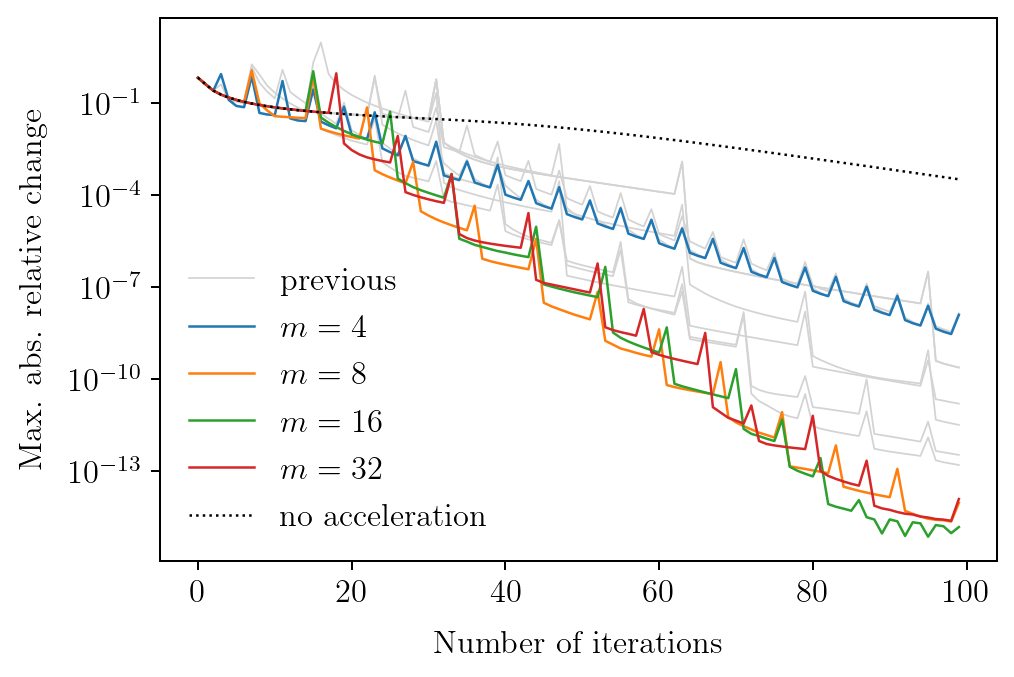

In [62]:
plt.figure(dpi=180)
# plt.plot(max_diffs_2,  label=r'$M=2$',  linewidth=1)

plt.plot(max_diffs_4,  linewidth=.7, c='lightgrey', label='previous')
plt.plot(max_diffs_8,  linewidth=.7, c='lightgrey')
plt.plot(max_diffs_16, linewidth=.7, c='lightgrey')
plt.plot(max_diffs_32, linewidth=.7, c='lightgrey')

plt.plot(max_diffs_4p,  linewidth=.7, c='lightgrey')
plt.plot(max_diffs_8p,  linewidth=.7, c='lightgrey')
plt.plot(max_diffs_16p, linewidth=.7, c='lightgrey')
plt.plot(max_diffs_32p, linewidth=.7, c='lightgrey')

plt.plot(max_diffs_ac_0_4,  linewidth=1, label='$m=4$')
plt.plot(max_diffs_ac_0_8,  linewidth=1, label='$m=8$')
plt.plot(max_diffs_ac_0_16, linewidth=1, label='$m=16$')
plt.plot(max_diffs_ac_0_32, linewidth=1, label='$m=32$')
# plt.plot(acc_diffs,       linewidth=1)
# plt.plot(ac2_diffs,       linewidth=1)
plt.yscale('log')
# plt.xlim((-5, 81))
# plt.ylim((1.0e-6, 20))
plt.xlabel('Number of iterations',            labelpad=9)
plt.ylabel('Max. abs. relative change', labelpad=9)


plt.plot(max_diffs_0, label='no acceleration',  c='k', linestyle='dotted', linewidth=1)
plt.legend(frameon=False, fancybox=False, loc='lower left')

plt.savefig('supervised_RNA.pdf', bbox_inches='tight')